In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.probability import FreqDist

import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import LsiModel, Phrases
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
!ls -a

.
..
.DS_Store
.ipynb_checkpoints
1_Wine_Explore.ipynb
2_WineNLP_Cleaning+LDA.ipynb
3_WineNLP_GensimModels_RecSys.ipynb
Metis Project 4- NLP Wine Presentation.pdf
README.md
WineNLP_2.ipynb
WineNLP_LSA_NMF.ipynb
df_cleaned.pickle
df_cleaned_final.pickle
df_test_cleaned.pickle
lda_cv_test_lemmat_2.pickle
low_occuring_words.pickle
stop_words.pickle


In [4]:
with open('df_cleaned_final.pickle', 'rb') as read_file1:
    df = pickle.load(read_file1)

# Retokenize lemmat_desc + create Gensim dictionary
- To use later Gensim steps, I needed to retokenize the already lemmatized/cleaned description text column.

In [15]:
# Retokenize the desc column (already lemmat, just need to retokenize). **Needed to use in Gensim**

def tokenize(desc):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(desc)
    return tokens

In [16]:
df['tokenized'] = df.lemmat_desc.apply(tokenize)

In [17]:
dictionary = corpora.Dictionary(df['tokenized'])

In [18]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df.tokenized]
doc_term_matrix 

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(0, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(0, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(35, 1),
  (37, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1)],
 [(57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1)],
 [(0, 1),
  (9, 1),
  (46, 1),
  (63, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1

# Pure gensim-- no cv/tfidf

In [14]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [15]:
def create_gensim_lsa_model(tokenized_col, number_of_topics, words):
   
    dictionary,doc_term_matrix = prepare_corpus(tokenized_col)
    
    #Generate model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    

## Determine optimal number of topics

In [16]:
def compute_coherence_values(dictionary,doc_term_matrix,tokenized_col, stop, start=2, step=3):
    """
    Taken from DataCamp tutorial on Gensim    
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start,stop,step):
        # Generate lsa model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokenized_col, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [17]:
# Plot coherence values
def plot_graph(tokenized_col,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(tokenized_col)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,tokenized_col,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [18]:
#start,stop,step=2,12,1
#plot_graph(df.tokenized,start,stop,step)
# Pretty low coherence even at max. Not sure what that means/ how to fix?

In [19]:
#compute_coherence_values(dictionary, doc_term_matrix, df.tokenized, stop=12)

In [21]:
# Run models
number_of_topics = 6 # Number taken from coherence plot
words=10
model = create_gensim_lsa_model(df.tokenized, number_of_topics,words)

[(0, '0.305*"cherry" + 0.295*"tannin" + 0.294*"finish" + 0.284*"black" + 0.246*"acidity" + 0.213*"ripe" + 0.186*"red" + 0.185*"spice" + 0.165*"berry" + 0.145*"plum"'), (1, '-0.403*"black" + 0.365*"acidity" + -0.299*"cherry" + 0.295*"apple" + -0.281*"tannin" + 0.249*"finish" + 0.184*"crisp" + 0.183*"citrus" + 0.175*"lemon" + 0.168*"white"'), (2, '-0.558*"finish" + 0.467*"acidity" + 0.300*"ripe" + 0.266*"tannin" + -0.217*"note" + -0.144*"nose" + -0.117*"oak" + -0.113*"plum" + 0.094*"red" + -0.092*"feel"'), (3, '0.531*"red" + 0.417*"cherry" + -0.376*"black" + -0.334*"ripe" + -0.194*"blackberry" + 0.194*"berry" + -0.156*"full" + 0.146*"acidity" + 0.140*"raspberry" + 0.119*"bright"'), (4, '0.438*"black" + -0.398*"berry" + 0.356*"cherry" + -0.270*"ripe" + -0.264*"red" + -0.216*"tannin" + -0.183*"finish" + 0.175*"apple" + 0.164*"white" + -0.152*"full"'), (5, '-0.439*"ripe" + -0.367*"cherry" + 0.309*"black" + 0.296*"acidity" + 0.255*"tannin" + 0.250*"berry" + 0.228*"finish" + -0.179*"full" + -

In [22]:
# Run models-- trying with more topics...
number_of_topcs = 10 
words=10
model = create_gensim_lsa_model(df.tokenized, number_of_topics,words)

[(0, '0.305*"cherry" + 0.295*"tannin" + 0.294*"finish" + 0.284*"black" + 0.246*"acidity" + 0.213*"ripe" + 0.186*"red" + 0.185*"spice" + 0.165*"berry" + 0.145*"plum"'), (1, '-0.403*"black" + 0.365*"acidity" + -0.299*"cherry" + 0.295*"apple" + -0.281*"tannin" + 0.249*"finish" + 0.184*"crisp" + 0.183*"citrus" + 0.175*"lemon" + 0.168*"white"'), (2, '-0.558*"finish" + 0.467*"acidity" + 0.300*"ripe" + 0.266*"tannin" + -0.217*"note" + -0.144*"nose" + -0.117*"oak" + -0.113*"plum" + 0.094*"red" + -0.092*"feel"'), (3, '0.531*"red" + 0.417*"cherry" + -0.376*"black" + -0.334*"ripe" + 0.194*"berry" + -0.194*"blackberry" + -0.156*"full" + 0.146*"acidity" + 0.140*"raspberry" + 0.120*"bright"'), (4, '0.438*"black" + -0.398*"berry" + 0.356*"cherry" + -0.270*"ripe" + -0.264*"red" + -0.216*"tannin" + -0.183*"finish" + 0.175*"apple" + 0.164*"white" + -0.152*"full"'), (5, '-0.440*"ripe" + -0.367*"cherry" + 0.308*"black" + 0.296*"acidity" + 0.256*"tannin" + 0.250*"berry" + 0.227*"finish" + -0.179*"full" + -

# Gensim w/ sklearn tfidf, with ngrams

In [24]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df = .5) 

In [25]:
fit = tfidf_vectorizer.fit(df.lemmat_desc)

In [26]:
doc_word_tfidf_lda = tfidf_vectorizer.transform(df.lemmat_desc).transpose()

In [28]:
corpus_tfidf_2 = matutils.Sparse2Corpus(doc_word_tfidf_lda)

In [29]:
id2word = dict((v,k) for k,v in tfidf_vectorizer.vocabulary_.items())

## 1,3 grams Gensim LDA model

In [105]:
# Gensim model with sklearn tfidf 1,3 grams
lda_tfidf_13 = models.LdaModel(corpus=corpus_tfidf_2, id2word=id2word, num_topics=15, passes=5)

In [106]:
lda_tfidf_13.print_topics(15)

[(0,
  '0.003*"scorched" + 0.003*"drunk" + 0.003*"scorched earth" + 0.003*"chilled" + 0.002*"bright crisp" + 0.002*"key" + 0.002*"closed" + 0.002*"elegantly structured" + 0.002*"acidity hint" + 0.002*"crunchy"'),
 (1,
  '0.003*"barnyard" + 0.003*"fermentation" + 0.003*"bacon" + 0.003*"turn" + 0.003*"detail" + 0.003*"beer" + 0.003*"root beer" + 0.003*"stem" + 0.003*"fat" + 0.002*"tannic finish"'),
 (2,
  '0.004*"provide" + 0.003*"tannin provide" + 0.003*"fine grained" + 0.003*"dole" + 0.002*"framework" + 0.002*"chopped herb" + 0.002*"lime acidity" + 0.002*"lends" + 0.002*"currant chocolate" + 0.002*"colored"'),
 (3,
  '0.004*"aggressive" + 0.002*"oak spice" + 0.002*"acidity provides" + 0.002*"lusty" + 0.002*"certain" + 0.002*"assertive tannin" + 0.002*"vanilla cinnamon" + 0.002*"smooth silky" + 0.002*"absolutely" + 0.002*"exquisite"'),
 (4,
  '0.010*"cherry" + 0.010*"tannin" + 0.010*"black" + 0.008*"red" + 0.008*"finish" + 0.007*"ripe" + 0.007*"berry" + 0.007*"spice" + 0.006*"acidity" +

In [7]:
# Plot the topic breakdown for a specific wine based on the model lda_tfidf_13
def get_topic_composition_and_plot(random_wine_index):
    '''
    Input: a wine index from the main df.
    Output: The wine's index and its description. A plot of the wine's topic makeup. The main topics' word \
    composition.
    '''
    random_wine_index = random_wine_index
    bow= dictionary.doc2bow(df.tokenized.loc[random_wine_index])
    print("Going to examine the topic composition of wine index # : {}".format(random_wine_index), "\n")
    print("The description for the randomly chosen wine is : {}".format(df.tokenized.loc[random_wine_index]), "\n")
    doc_distribution = np.array([tup for tup in lda_tfidf_13.get_document_topics(bow=bow)])
    x_val = [x[0] for x in doc_distribution]
    y_val = [x[1] for x in doc_distribution]
    
    # Print the top topics for the wine along with the topics' composition
    for i in doc_distribution[:,0]:
        print(int(i),lda_tfidf_13.show_topic(int(i), topn=10), "\n")
    
    # bar plot of topic distribution for this document
    fig, ax = plt.subplots(figsize=(12,6));
    bars = ax.bar(x_val, y_val)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Contribution', fontsize=15)
    ax.set_title("Topic Distribution for Wine " + str(random_wine_index), fontsize=20)
    ax.set_xticks(np.linspace(0,15,16))
    fig.tight_layout()
    plt.show();
    return plt    


In [8]:
#get_topic_composition_and_plot(124)
get_topic_composition_and_plot(3436)

NameError: name 'dictionary' is not defined

In [20]:
dictionary = corpora.Dictionary(df.tokenized)
corpus = [dictionary.doc2bow(doc) for doc in df.tokenized]

In [21]:
tfidf = models.TfidfModel(corpus)

In [22]:
# From now on, tfidf is treated as a read-only object that can be used to convert any vector from the old 
# representation (bag-of-words integer counts) to the new representation (TfIdf real-valued weights):
doc_bow = [(0,1), (1,1)]
print(tfidf[doc_bow])

[(0, 0.38603777338539297), (1, 0.9224829741082747)]


In [23]:
corpus_tfidf_final = [dictionary.doc2bow(doc) for doc in df.tokenized]
corpus_tfidf_final

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(0, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(0, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(35, 1),
  (37, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1)],
 [(57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1)],
 [(0, 1),
  (9, 1),
  (46, 1),
  (63, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1

In [25]:
#lsi_model_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=15)  # initialize an LSI transformation

In [26]:
#corpus_lsi_tfidf = lsi_model_tfidf[corpus_tfidf]  # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [93]:
lsi_model_tfidf.print_topics(15)

[(0,
  '0.179*"black" + 0.176*"tannin" + 0.171*"acidity" + 0.170*"ripe" + 0.163*"cherry" + 0.159*"red" + 0.141*"spice" + 0.138*"berry" + 0.134*"finish" + 0.127*"full"'),
 (1,
  '0.274*"apple" + 0.252*"crisp" + -0.244*"black" + 0.209*"citrus" + 0.191*"lemon" + 0.186*"pear" + 0.182*"acidity" + -0.171*"tannin" + -0.170*"cabernet" + 0.169*"white"'),
 (2,
  '0.227*"wood" + 0.205*"aging" + 0.196*"ripe" + 0.195*"ready" + 0.165*"structure" + -0.145*"white" + -0.145*"finish" + -0.143*"nose" + 0.138*"attractive" + 0.138*"texture"'),
 (3,
  '-0.285*"cabernet" + 0.262*"alongside" + -0.197*"sauvignon" + -0.159*"blend" + -0.152*"sweet" + 0.142*"bright" + -0.142*"oak" + -0.141*"merlot" + 0.140*"juicy" + 0.140*"white"'),
 (4,
  '0.464*"cabernet" + 0.349*"sauvignon" + 0.284*"merlot" + 0.264*"blend" + 0.220*"franc" + 0.154*"crisp" + 0.149*"bright" + -0.132*"full" + 0.127*"red" + -0.121*"oak"'),
 (5,
  '0.344*"red" + 0.312*"soft" + 0.201*"raspberry" + 0.174*"berry" + -0.173*"wood" + 0.165*"pinot" + 0.162

In [27]:
dictionary.token2id # Dictionary is the mapping of words to index. These are just mappings not values/occurence

{'acidity': 0,
 'alongside': 1,
 'apple': 2,
 'brimstone': 3,
 'brisk': 4,
 'broom': 5,
 'citrus': 6,
 'dried': 7,
 'expressive': 8,
 'herb': 9,
 'include': 10,
 'offering': 11,
 'overly': 12,
 'tropical': 13,
 'already': 14,
 'although': 15,
 'berry': 16,
 'better': 17,
 'certainly': 18,
 'drinkable': 19,
 'filled': 20,
 'firm': 21,
 'freshened': 22,
 'juicy': 23,
 'red': 24,
 'ripe': 25,
 'smooth': 26,
 'still': 27,
 'structured': 28,
 'tannin': 29,
 'crisp': 30,
 'dominate': 31,
 'fermented': 32,
 'flesh': 33,
 'lime': 34,
 'pineapple': 35,
 'poke': 36,
 'rind': 37,
 'snappy': 38,
 'stainless': 39,
 'tart': 40,
 'underscoring': 41,
 'astringent': 42,
 'bit': 43,
 'blossom': 44,
 'drizzled': 45,
 'finish': 46,
 'giving': 47,
 'guava': 48,
 'honey': 49,
 'lemon': 50,
 'mango': 51,
 'note': 52,
 'opulent': 53,
 'pith': 54,
 'slightly': 55,
 'start': 56,
 'across': 57,
 'characteristic': 58,
 'come': 59,
 'country': 60,
 'earthy': 61,
 'hearty': 62,
 'herbal': 63,
 'much': 64,
 'nonethe

In [28]:
#lsi_model_tfidf.show_topics

# Final Gensim LDA Model

In [24]:
lda_model_tfidf = models.LdaModel(corpus_tfidf_final, id2word=dictionary, num_topics=15, passes=20 )  # initialize an LDA transformation

In [25]:
lda_model_tfidf.print_topics(15)

[(0,
  '0.063*"finish" + 0.052*"berry" + 0.037*"herbal" + 0.033*"plum" + 0.030*"feel" + 0.021*"red" + 0.017*"note" + 0.014*"earthy" + 0.014*"bit" + 0.012*"slightly"'),
 (1,
  '0.045*"acidity" + 0.040*"ripe" + 0.037*"tannin" + 0.020*"full" + 0.020*"well" + 0.019*"wood" + 0.019*"texture" + 0.019*"red" + 0.018*"black" + 0.018*"structure"'),
 (2,
  '0.051*"apple" + 0.042*"white" + 0.041*"citrus" + 0.039*"acidity" + 0.036*"crisp" + 0.024*"pear" + 0.024*"bright" + 0.024*"lemon" + 0.016*"mineral" + 0.014*"finish"'),
 (3,
  '0.038*"herb" + 0.032*"note" + 0.031*"spice" + 0.026*"finish" + 0.025*"cherry" + 0.019*"bodied" + 0.019*"dried" + 0.017*"full" + 0.017*"cranberry" + 0.014*"followed"'),
 (4,
  '0.038*"nose" + 0.035*"strawberry" + 0.034*"color" + 0.026*"show" + 0.024*"rosé" + 0.016*"red" + 0.016*"juice" + 0.015*"sip" + 0.015*"tart" + 0.015*"touch"'),
 (5,
  '0.058*"cherry" + 0.040*"pinot" + 0.035*"dry" + 0.028*"oak" + 0.027*"raspberry" + 0.024*"sweet" + 0.022*"noir" + 0.016*"blackberry" + 0.

# Testing final model from above with dif params (topic number, passes, etc)

In [645]:
#lda_model_tfidf_20 = models.LdaModel(corpus_tfidf_final, id2word=dictionary, num_topics=20, passes=5)  # initialize an LDA transformation

In [648]:
#lda_model_tfidf_20.print_topics(20)

[(0,
  '0.037*"much" + 0.035*"vintage" + 0.021*"although" + 0.020*"hard" + 0.016*"lack" + 0.015*"still" + 0.014*"dry" + 0.014*"could" + 0.014*"richness" + 0.013*"result"'),
 (1,
  '0.055*"cherry" + 0.048*"red" + 0.031*"spice" + 0.026*"herb" + 0.024*"bright" + 0.024*"acidity" + 0.023*"raspberry" + 0.023*"berry" + 0.020*"cranberry" + 0.020*"finish"'),
 (2,
  '0.070*"tannin" + 0.041*"black" + 0.040*"firm" + 0.037*"wood" + 0.037*"aging" + 0.036*"ripe" + 0.035*"structure" + 0.031*"acidity" + 0.022*"dense" + 0.022*"structured"'),
 (3,
  '0.027*"nose" + 0.023*"sip" + 0.021*"wet" + 0.017*"herbaceous" + 0.016*"gooseberry" + 0.016*"everything" + 0.015*"meet" + 0.015*"flesh" + 0.015*"behind" + 0.015*"show"'),
 (4,
  '0.031*"food" + 0.026*"alcohol" + 0.026*"peppery" + 0.021*"zinfandel" + 0.020*"dry" + 0.018*"make" + 0.018*"friendly" + 0.016*"cheese" + 0.016*"rustic" + 0.015*"making"'),
 (5,
  '0.041*"acidity" + 0.041*"apple" + 0.036*"lemon" + 0.031*"finish" + 0.029*"pear" + 0.027*"white" + 0.022*"

# Need to reset df index so the iloc matching works with later doc X topic df/matrix

In [26]:
df.reset_index(inplace=True)

# Explore final model

## Main fx to explore random wines

In [27]:
# Important to change the doc_distribution and model params when resusing this fx with different models
# Below is with the params / doc dist of the final LDA model

def get_topic_composition_and_plot(random_wine_index):
    '''
    Input: a wine index from the main df.
    Output: The wine's index and its description. A plot of the wine's topic makeup. The main topics' word \
    composition.
    '''
    random_wine_index = random_wine_index
    bow= dictionary.doc2bow(df.tokenized.iloc[random_wine_index])
    print("Going to examine the topic composition of wine index # : {}".format(random_wine_index), "\n")
    print("The description for the randomly chosen wine is : {}".format(df.tokenized.iloc[random_wine_index]), "\n")
    doc_distribution = np.array([tup for tup in lda_model_tfidf.get_document_topics(bow=bow)])
    x_val = [x[0] for x in doc_distribution]
    y_val = [x[1] for x in doc_distribution]
    
    # Print the top topics for the wine along with the topics' composition
    for i in doc_distribution[:,0]:
        print(int(i),lda_model_tfidf.show_topic(int(i), topn=10), "\n")
    
    # bar plot of topic distribution for this document
    fig, ax = plt.subplots(figsize=(10,6));
    bars = ax.bar(x_val, y_val)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Contribution', fontsize=15)
    ax.set_title("Topic Distribution for Wine " + str(random_wine_index), fontsize=20)
    ax.set_xticks(np.linspace(0,15,16))
    fig.tight_layout()
    plt.show();
    return plt    


In [1368]:
#df[df.description == 'Tight, textured and mineral, this wine just hints at the fruit to come. It is dark, brooding and concentrated, with black-plum flavors just beginning to shine through the dry texture. It needs aging, so drink from 2022.']

In [28]:
df.iloc[119987]

index                                                     129970
country                                                   France
description    Big, rich and off-dry, this is powered by inte...
designation                        Lieu-dit Harth Cuvée Caroline
points                                                        90
price                                                         21
province                                                  Alsace
region_1                                                  Alsace
region_2                                                     999
taster_name                                           Roger Voss
title          Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...
variety                                           Gewürztraminer
winery                                          Domaine Schoffit
vintage                                                     2012
log_price                                                3.04452
clean_desc     big  rich 

Going to examine the topic composition of wine index # : 119987 

The description for the randomly chosen wine is : ['dry', 'powered', 'intense', 'spiciness', 'rounded', 'texture', 'lychee', 'dominate', 'giving', 'opulent', 'feel', 'aftertaste'] 

1 [('acidity', 0.045206126), ('ripe', 0.040149942), ('tannin', 0.037170377), ('full', 0.020069713), ('well', 0.020064825), ('wood', 0.019324472), ('texture', 0.019228356), ('red', 0.01861052), ('black', 0.018364513), ('structure', 0.017832164)] 

11 [('spice', 0.031775616), ('tone', 0.017571894), ('cherry', 0.016311686), ('mouthfeel', 0.014621403), ('meat', 0.014183352), ('bright', 0.013320173), ('berry', 0.013288307), ('show', 0.013136892), ('mouth', 0.012705979), ('exotic', 0.011556218)] 

14 [('finish', 0.04278387), ('sweet', 0.038803343), ('vanilla', 0.022701496), ('apple', 0.018120551), ('soft', 0.017978568), ('melon', 0.017672738), ('full', 0.016977048), ('creamy', 0.01660583), ('feel', 0.015563642), ('oak', 0.015462205)] 



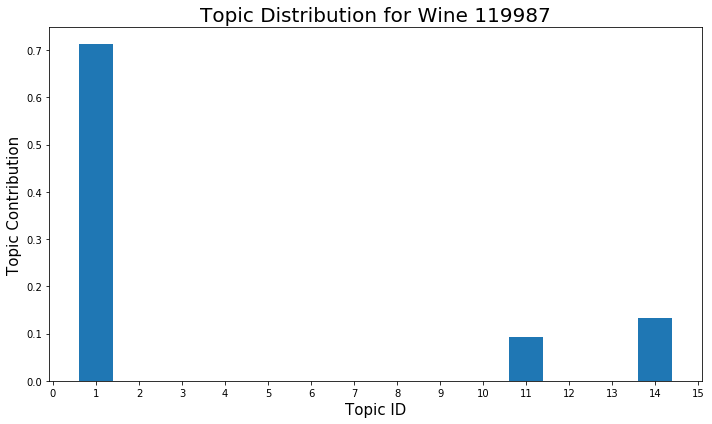

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [29]:
get_topic_composition_and_plot(119987)

Going to examine the topic composition of wine index # : 284 

The description for the randomly chosen wine is : ['huge', 'defines', 'jammy', 'concentrated', 'ripe', 'soft', 'minty', 'echo', 'nose', 'thickness', 'density', 'prune', 'raisin', 'tea', 'blackberry', 'borderline', 'syrupy', 'finish', 'smooth', 'pure', 'much', 'spine', 'modern', 'sooner', 'rather', 'later'] 

3 [('level', 0.022543006), ('value', 0.02204831), ('sourced', 0.019270957), ('several', 0.017633041), ('producer', 0.015531), ('rubber', 0.015124127), ('entry', 0.014406522), ('root', 0.012760032), ('remains', 0.012369155), ('bramble', 0.012351544)] 

4 [('cherry', 0.06285188), ('pinot', 0.051200945), ('raspberry', 0.038594417), ('dry', 0.029778425), ('red', 0.029152147), ('sweet', 0.024840843), ('noir', 0.024102278), ('strawberry', 0.021758435), ('acidity', 0.021350948), ('soft', 0.018919742)] 

6 [('tone', 0.01839942), ('spice', 0.016170228), ('intensity', 0.01553501), ('grape', 0.0152675165), ('show', 0.0129665835), 

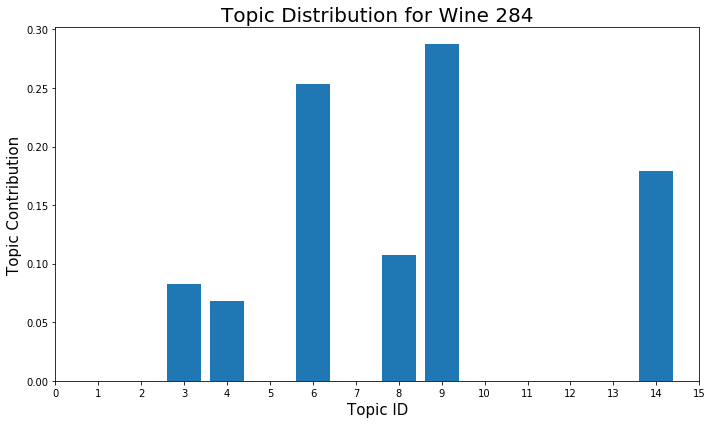

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [43]:
get_topic_composition_and_plot(284)

# Run a random wine through model

In [1372]:
# # Select a random wine index
# new_wine_index = np.random.randint(len(df.lemmat_desc))
# print(new_wine_index)

In [44]:
new_wine_index = 284

In [45]:
# New wine as bag or words
new_wine_bow = dictionary.doc2bow(df.tokenized.loc[new_wine_index])
#print(new_wine_bow)

In [46]:
print(df.tokenized.loc[284])

['huge', 'defines', 'jammy', 'concentrated', 'ripe', 'soft', 'minty', 'echo', 'nose', 'thickness', 'density', 'prune', 'raisin', 'tea', 'blackberry', 'borderline', 'syrupy', 'finish', 'smooth', 'pure', 'much', 'spine', 'modern', 'sooner', 'rather', 'later']


In [47]:
# Removing the[1] here will get the tuple with topic # and dist percentage
new_doc_distribution = np.array([tup[1] for tup in lda_model_tfidf.get_document_topics(bow=new_wine_bow)])

In [48]:
new_doc_distribution

array([0.08227026, 0.06782769, 0.25346035, 0.10771537, 0.2873506 ,
       0.17914806], dtype=float32)

# Convert from bow to sparse matrix to dense matrix to pandas

In [32]:
corpus_lda = lda_model_tfidf[corpus] # Transforming out of bow

In [34]:
# convert bag of words corpus into sparse matrix with docs as columns
csc_mat_lda = gensim.matutils.corpus2csc(corpus_lda)
print(csc_mat_lda.shape)

(15, 119988)


In [35]:
# turn documents into rows, and convert to numpy array-- this is the doc X topic matrix
doc_topic_array_lda = csc_mat_lda.T.toarray()

In [37]:
doc_topic_array_lda.shape

(119988, 15)

In [38]:
doc_topic_array_lda[0]

array([0.09078802, 0.        , 0.45155519, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.29408941, 0.        ,
       0.        , 0.1177132 , 0.        , 0.        , 0.        ])

In [53]:
df_lda = pd.DataFrame(doc_topic_array_lda)
df_lda.columns = [f'topic_{x}' for x in np.arange(0,len(df_lda.columns))]

In [55]:
df_lda.loc[284]

topic_0     0.000000
topic_1     0.000000
topic_2     0.000000
topic_3     0.082272
topic_4     0.067868
topic_5     0.000000
topic_6     0.253451
topic_7     0.000000
topic_8     0.107688
topic_9     0.287275
topic_10    0.000000
topic_11    0.000000
topic_12    0.000000
topic_13    0.000000
topic_14    0.179217
Name: 284, dtype: float64

In [61]:
# #print(df_lda.loc[1234])
# print(df_lda.shape)
# print(df_lda.index, "\n")
# print(df.shape)
# print(df.index)

# Jensen shannon similarity

In [62]:
matrix = np.array([[tup[1] for tup in lst] for lst in lda_model_tfidf[corpus_tfidf_final]])

In [63]:
matrix

array([list([0.13685708, 0.72798645, 0.08514968]),
       list([0.76829284, 0.1835512]),
       list([0.075402394, 0.5469206, 0.16795444, 0.07632441, 0.08568686]),
       ..., list([0.12999123, 0.08350902, 0.551472, 0.17860924]),
       list([0.09554379, 0.5105506, 0.26535928, 0.08271108]),
       list([0.09287078, 0.12737027, 0.64131033, 0.0820291])],
      dtype=object)

In [64]:
# Works fine when grabbing from the DF-- need to make sure these steps work with an unseen wine

# new_wine_index = 11111
# new_wine_bow= dictionary.doc2bow(df.tokenized.iloc[new_wine_index])
# print("Going to examine the topic composition of wine index # : {}".format(new_wine_index), "\n")
# print("The description for the randomly chosen wine is : {}".format(df.tokenized.iloc[new_wine_index]), "\n")
# new_wine_doc_distribution = np.array([tup[1] for tup in lda_model_tfidf.get_document_topics(bow=new_wine_bow)])


# Test with working full matrix

In [65]:
doc_topic_array_lda[284] # This way has the full 15 topics and non zeros where the topics contribute

array([0.        , 0.        , 0.        , 0.08227248, 0.06786834,
       0.        , 0.25345108, 0.        , 0.10768843, 0.2872752 ,
       0.        , 0.        , 0.        , 0.        , 0.17921677])

In [66]:
new_wine = doc_topic_array_lda[284].T
print(new_wine.shape)

(15,)


In [67]:
new_wine

array([0.        , 0.        , 0.        , 0.08227248, 0.06786834,
       0.        , 0.25345108, 0.        , 0.10768843, 0.2872752 ,
       0.        , 0.        , 0.        , 0.        , 0.17921677])

In [68]:
full_matrix = doc_topic_array_lda
print(full_matrix.shape)

(119988, 15)


# Final functions + recommendations
- Need to get these streamlined into one callable fx
- Need to add cleaning steps for new unseen wines

In [69]:
def jensen_shannon(query, matrix):
    import numpy as np
    import scipy.stats
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    print(type(p), type(q))
    m = 0.5*(p + q)
    return np.sqrt(0.5*(scipy.stats.entropy(p,m) + scipy.stats.entropy(q,m)))

In [70]:
def get_most_similar_wines(query,matrix,k=20):
    """
    This function implements the JSD function and returns the top k INDICIES of the
    smallest JSD.
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances for query vs WHOLE matrix
    distances = sorted(sims,reverse=True)
    #print(distances)
    #print(sims.argsort())
    most_similar_k = sims.argsort()[:k]
    exploration_k = sims.argsort()[30: 30+k]
    #print("Exploration wine IDs: {}".format(exploration_k))
    #print("Most similar wine ilocs: {}".format(most_similar_k))
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

## Get rec via final functions

In [75]:
# Get most similar wines (the indices) to the wine in question (here, "new_wine")
most_similar_wine_ilocs = get_most_similar_wines(new_wine,full_matrix)

most_similar_wine_ilocs

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


array([   284,   3436,  52985,  59716, 101170,  37219,  43017,  99717,
        80216,   9732, 101690,  40619,  66589,  14478,   1068,   1157,
        67821, 100428,   8895,   8894])

# Link topic model df to original df to include price, points, and more cols
- Here we need to merge the topic modeling df (with topic distributions for each wine) to the original df with attributes like: price, region, name, etc.
- This allows us to link back wine's info when recommending

In [76]:
df = df.reset_index()

In [77]:
df_lda = df_lda.reset_index()

In [78]:
# Merge main df with df_lda topic model info
df_merged = df.merge(df_lda)
df_merged

,level_0,index,country,description,designation,points,price,province,region_1,region_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,999,999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.768293,0.183551,0.000000,0.000000,0.000000
2,2,2,US,"Tart and snappy, the flavors of lime flesh and...",a,87,14.0,Oregon,Willamette Valley,Willamette Valley,...,0.000000,0.000000,0.546923,0.000000,0.000000,0.167953,0.000000,0.000000,0.076324,0.085686
3,3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,999,...,0.000000,0.000000,0.715087,0.000000,0.141088,0.000000,0.099374,0.000000,0.000000,0.000000
4,4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,...,0.000000,0.114902,0.000000,0.000000,0.124945,0.000000,0.000000,0.000000,0.000000,0.614486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111387,111387,119983,US,Inky black color makes it evident this is a va...,a,90,35.0,California,Napa Valley,Napa,...,0.000000,0.000000,0.000000,0.070880,0.058306,0.000000,0.065187,0.000000,0.000000,0.000000
111388,111388,119984,Italy,"Raspberry jam, leather, moist soil and a balsa...",Basarin Vigna Gianmatè,90,55.0,Piedmont,Barbaresco,999,...,0.072831,0.000000,0.000000,0.312385,0.000000,0.000000,0.000000,0.257281,0.000000,0.000000
111389,111389,119985,Argentina,Ripe earthy berry aromas are supported by more...,Particular,90,31.0,Mendoza Province,999,999,...,0.000000,0.000000,0.000000,0.083509,0.000000,0.551297,0.178832,0.000000,0.000000,0.000000
111390,111390,119986,US,"Dark yellow-hay in color, this is a waxy, sump...",Eau de Tony,90,40.0,California,Napa Valley,Napa,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.510538,0.265374,0.000000,0.000000,0.082711


In [91]:
df_merged.columns

Index(['level_0', 'index', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name', 'title',
       'variety', 'winery', 'vintage', 'log_price', 'clean_desc',
       'lemmat_desc', 'stem_desc', 'tokenized', 'topic_0', 'topic_1',
       'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
       'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13',
       'topic_14'],
      dtype='object')

In [98]:
# Get a list of column names from the topic modeling df
topic_cols = ['topic_' + str(i) for i in range(0,15)]

In [101]:
# Only the topic distribution values (basically the pre merged lda data)
df_merged[topic_cols].values.shape

(111392, 15)

# Final function with price filter
- Here we incorporate a price filter so we can recommend similar wines that are in a certain price range

In [102]:
def rec_wines(new_wine, df_merged, max_price):
    '''Function takes in a new wines topic distribution, max price, and the df. Returns similar wines in the price\
    range.'''
    max_price = max_price
    topic_cols = ['topic_' + str(i) for i in range(0,15)]
    
    df_filtered = df_merged[df_merged.price <= max_price]
    df_filtered_values = df_filtered[topic_cols].values
    print(df_filtered_values.shape)
    
    # Here I can add a cleaner/lemmatization/stripper to catch unseen wine, for now will do manually
    # For now new_wine assumes a wine that's already cleaned. Need it's dist though
    most_similar_wine_ilocs = get_most_similar_wines(new_wine, df_filtered_values)
    
    return df_filtered.iloc[most_similar_wine_ilocs]
    

In [103]:
rec_wines(new_wine, df_merged, 50)

(86574, 15)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


,level_0,index,country,description,designation,points,price,province,region_1,region_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
3426,3426,3436,US,Aromas of vanilla and cocoa mix with red fruit...,Vineyard Series Clifton Vineyards,88,28.0,Washington,Wahluke Slope,Columbia Valley,...,0.000000,0.120769,0.0,0.159281,0.274567,0.0,0.000000,0.0,0.000000,0.219824
95124,95124,101170,US,The aromas in this bottling from Brian and Ste...,Luna Matta Vineyard,92,45.0,California,Paso Robles,Central Coast,...,0.066659,0.215603,0.0,0.083714,0.371177,0.0,0.000000,0.0,0.000000,0.077290
36406,36406,37219,US,This cool-vintage wine offers aromas of vanill...,Discovery Vineyard,88,44.0,Washington,Horse Heaven Hills,Columbia Valley,...,0.000000,0.178434,0.0,0.084660,0.330840,0.0,0.000000,0.0,0.089873,0.189168
41945,41945,43017,Germany,Faint whiffs of apple and fresh herb open this...,Dürkheimer Dry-Style,88,19.0,Pfalz,999,999,...,0.091359,0.189406,0.0,0.139531,0.234696,0.0,0.000000,0.0,0.000000,0.167165
93831,93831,99717,France,This is a dry wine from the Saint-Emilion co-o...,a,86,13.0,Bordeaux,Castillon Côtes de Bordeaux,999,...,0.000000,0.301536,0.0,0.209021,0.146087,0.0,0.000000,0.0,0.000000,0.073129
76253,76253,80216,Italy,"This opens with aromas of wet leaves, forest f...",Promemoria,86,40.0,Tuscany,Toscana,999,...,0.000000,0.267157,0.0,0.000000,0.244512,0.0,0.000000,0.0,0.000000,0.248625
9692,9692,9732,US,Entirely barrel-fermented in 20% new French oa...,a,90,40.0,California,Spring Mountain District,Napa,...,0.000000,0.225182,0.0,0.069646,0.330463,0.0,0.000000,0.0,0.000000,0.201205
95583,95583,101690,Portugal,"Big, chunky and ripe, with earthy aromas follo...",a,87,18.0,Alentejano,999,999,...,0.000000,0.179978,0.0,0.255920,0.245010,0.0,0.000000,0.0,0.000000,0.213772
39663,39663,40619,France,There is a yeasty rounded freshness on the nos...,Vieilles Vignes,89,22.0,Alsace,Alsace,999,...,0.000000,0.124066,0.0,0.113729,0.356470,0.0,0.000000,0.0,0.000000,0.300959
14368,14368,14478,France,"This wine is bone dry, very crisp and fruity. ...",a,84,12.0,Bordeaux,Bordeaux Rosé,999,...,0.000000,0.316535,0.0,0.068309,0.340882,0.0,0.000000,0.0,0.000000,0.112456


# Test on unseen wine brought to class-- flaco tempranilllo

In [113]:
flaco_desc = 'Brilliant ruby-red. A highly perfumed nose evokes ripe red berries and floral pastilles, and a hint of white pepper lends a spicy touch. Plush, seamless and gently sweet, offering raspberry and cherry compote flavors that become more energetic on the back half. Emphatically fruity and supple in texture, finishing with just a hint of smooth, harmonious tannins. This fruit-driven, very appealing wine offers superb value.'
flaco_lemmat = 'brilliant red highly perfumed nose evokes ripe red berry floral pastille hint white lends spicy touch plush seamless gently sweet offering raspberry cherry compote become energetic half supple texture finishing hint smooth harmonious tannin driven appealing superb value'
flaco_token = tokenize(flaco_lemmat)
flaco_bow = dictionary.doc2bow(flaco_token)
flaco_topic_dist = np.array([tup[1] for tup in lda_model_tfidf.get_document_topics(bow=flaco_bow)])

In [129]:
flaco_lemmat

'brilliant red highly perfumed nose evokes ripe red berry floral pastille hint white lends spicy touch plush seamless gently sweet offering raspberry cherry compote become energetic half supple texture finishing hint smooth harmonious tannin driven appealing superb value'

In [130]:
flaco_topic_dist

array([0.06868262, 0.10711462, 0.03255021, 0.10949306, 0.07134335,
       0.11081462, 0.11950586, 0.30646643, 0.06349874], dtype=float32)

In [122]:
doc_topic_array_lda[0]

array([0.1369397 , 0.        , 0.72790462, 0.08514889, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [125]:
lda_model_tfidf.get_document_topics(bow=flaco_bow)

[(1, 0.06868276),
 (2, 0.107097246),
 (3, 0.03254974),
 (4, 0.109462425),
 (6, 0.07134043),
 (10, 0.110812254),
 (11, 0.1195168),
 (12, 0.30652657),
 (14, 0.06348135)]

# Having an issue with the dist not being out of the full 15 possible...

In [89]:
rec_wines(flaco_topic_dist, df_merged, 50)

(86574, 15)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


ValueError: operands could not be broadcast together with shapes (9,1) (15,86574) 

In [90]:
for index, score in sorted(lda_model_tfidf[flaco_bow], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.30646640062332153	 Topic: 0.035*"bodied" + 0.035*"finish" + 0.034*"full" + 0.031*"cherry" + 0.030*"spice"
Score: 0.11953254789113998	 Topic: 0.063*"acidity" + 0.042*"ripe" + 0.031*"crisp" + 0.028*"texture" + 0.025*"full"
Score: 0.11080261319875717	 Topic: 0.060*"tannin" + 0.043*"cabernet" + 0.034*"black" + 0.027*"sauvignon" + 0.026*"firm"
Score: 0.10948140919208527	 Topic: 0.063*"cherry" + 0.051*"pinot" + 0.039*"raspberry" + 0.030*"dry" + 0.029*"red"
Score: 0.10709842294454575	 Topic: 0.041*"acidity" + 0.034*"lemon" + 0.034*"white" + 0.033*"finish" + 0.032*"apple"
Score: 0.0713445246219635	 Topic: 0.018*"tone" + 0.016*"spice" + 0.016*"intensity" + 0.015*"grape" + 0.013*"show"
Score: 0.06868233531713486	 Topic: 0.136*"oak" + 0.069*"vanilla" + 0.045*"toast" + 0.021*"toasted" + 0.020*"toasty"
Score: 0.06351083517074585	 Topic: 0.066*"finish" + 0.046*"berry" + 0.034*"plum" + 0.030*"herbal" + 0.027*"feel"
Score: 0.03255043551325798	 Topic: 0.023*"level" + 0.022*"value" + 0.019*"sou